# Bootstrapping
This experiment is designed to evaluate the robustness of the parameter samples against resampling as shown in the lecture.

In [1]:
import sys
sys.path.append("../")
from src import data
import pandas as pd
import numpy as np
import scipy.stats

Let's get the two dataframes

In [2]:
pop_songs, non_pop_songs = data.get_split_dfs(drop_columns=['id','name','popularity','key'])

We try to calculate the F value now for 10000 bootstrapped sampled each to estimate our certainty about the variance calculation.

In [3]:
F_values = pd.DataFrame()
for i in range(10000):
    pop_resampled = pop_songs.sample(frac=1, replace=True)
    assert pop_resampled.shape == (pop_songs.shape)
    non_pop_resampled = non_pop_songs.sample(frac=1, replace=True)
    assert non_pop_resampled.shape == (non_pop_resampled.shape)
    F = non_pop_resampled.var() / pop_resampled.var()
    F_values = F_values.append(F, ignore_index=True)

Let's analyse the variance estimations for all samples

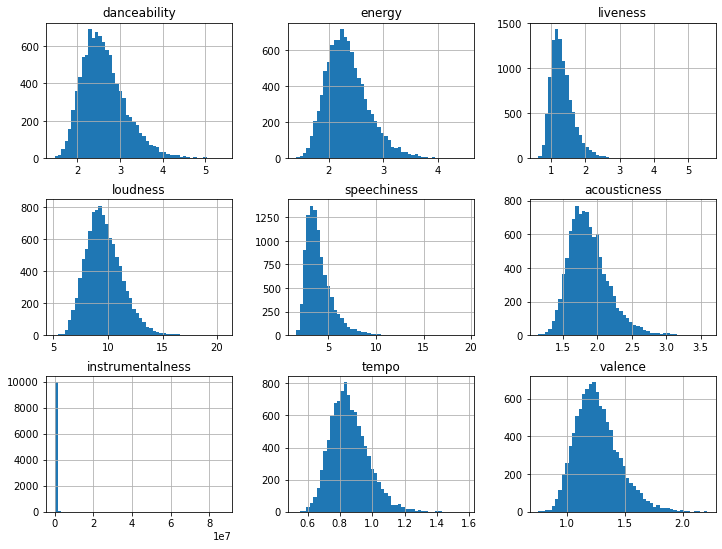

In [4]:
F_values.hist(figsize=(12,9), bins=50)
print('')

Let's find 95% HDIs

In [13]:
for col in F_values.columns:
    bins = np.histogram(np.clip(F_values.loc[:,[col]], 0, 10e5), bins=1000)

    weights = bins[0] / sum(bins[0])
    ordered_weights = weights[np.flip(np.argsort(bins[0]))]
    limit = np.min(np.where(np.cumsum(ordered_weights) > .95))

    hdi_bins = np.append(weights > weights[limit], False)
    lower = np.min(bins[1][hdi_bins])
    upper = np.max(bins[1][hdi_bins])
    print(lower, upper)

1.7223572278955863 3.78138376822523
1.7512779958498261 2.940111296873041
0.783290393634436 1.9178804251777262
7.401313782551707 11.597905298200931
1.9035169088028674 7.968575048702465
1.4995601373283622 2.150808392583219
111.42116779200356 999000.1114211677
0.7137609241544381 0.9823485323960406
0.9809726049357477 1.5009595993512017


Let's calculate how many of those values are above the critical value each:

In [6]:
f_crit = scipy.stats.f.ppf(q=(1-0.05/9), dfn=(len(non_pop_songs)-1), dfd=(len(pop_songs))-1)
np.mean(F_values > f_crit) * 100

danceability         99.74
energy               99.32
liveness             17.05
loudness            100.00
speechiness          99.98
acousticness         82.59
instrumentalness    100.00
tempo                 0.00
valence               4.70
dtype: float64

Let's see what appens if we resample equal sample sizes

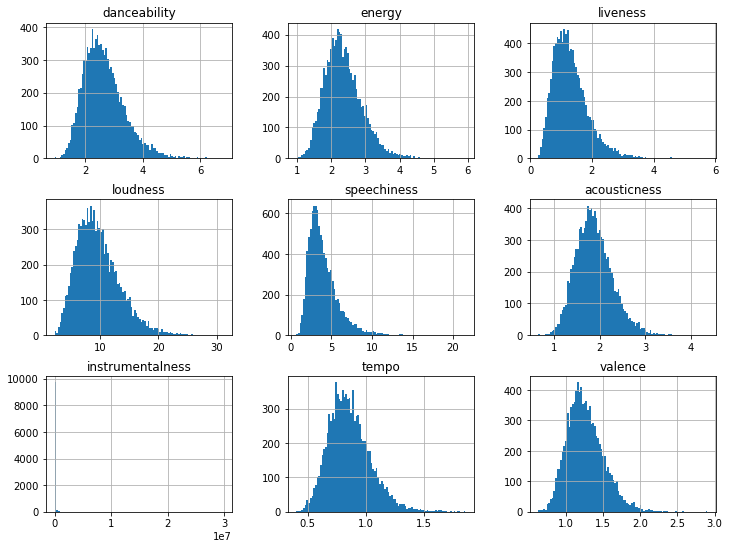

In [7]:
F_values_eq = pd.DataFrame()
for i in range(10000):
    pop_resampled = pop_songs.sample(frac=1, replace=True)
    assert pop_resampled.shape == (pop_songs.shape)
    non_pop_resampled = non_pop_songs.sample(n=pop_songs.shape[0], replace=True)
    assert non_pop_resampled.shape == (pop_songs.shape) # now check that sample sizes match
    F = non_pop_resampled.var() / pop_resampled.var()
    F_values_eq = F_values_eq.append(F, ignore_index=True)
F_values_eq.hist(figsize=(12,9), bins=100)
print('')